# Import Libraries

In [216]:
import quandl
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


# Import Dataset

In [218]:
# Create Path
path=r'C:\Users\baidy\Downloads\citibike_cleaned.csv'

In [219]:
# Import datadet
df=pd.read_csv(os.path.join(path))

In [220]:
# Check the data types
df.dtypes.head(10)

trip_id                     object
bike_id                      int64
weekday                     object
start_hour                   int64
start_time                  object
start_station_id             int64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_time                    object
dtype: object

In [221]:
# checking if have the necessory columns to create datetime
df.columns.tolist()

['trip_id',
 'bike_id',
 'weekday',
 'start_hour',
 'start_time',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_time',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'trip_duration',
 'subscriber',
 'birth_year',
 'gender',
 'age',
 'gender_desc']

# Create time series based on the date components, since don't have specific dates, will create a time series by aggregating by weekday and hour

In [223]:
#  Count trips by weekday and hour
weekday_hour_counts=df.groupby(['weekday','start_hour']).size().reset_index(name='trip_count')

In [224]:
# Map weekdays to numbers for proper ordering
weekday_map={'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6}
weekday_hour_counts['weekday_num']=weekday_hour_counts['weekday'].map(weekday_map)

In [225]:
# Sort by weekday and hour
weekday_hour_counts=weekday_hour_counts.sort_values(['weekday_num','start_hour'])

In [226]:
# trip counts by weekday and hour
weekday_hour_counts.head()

,weekday,start_hour,trip_count,weekday_num
24,Mon,0,62,0
25,Mon,1,43,0
26,Mon,2,18,0
27,Mon,3,9,0
28,Mon,4,9,0


In [227]:
# Create time series by hour of the week(0-167)
weekday_hour_counts['hour_of_week']=weekday_hour_counts['weekday_num']*24+weekday_hour_counts['start_hour']

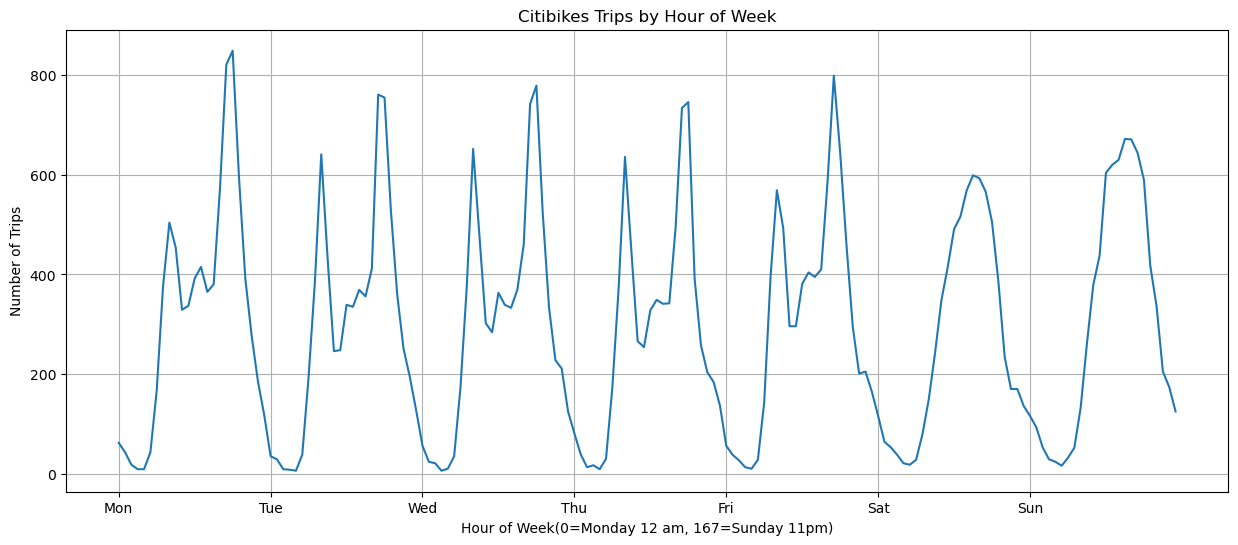

In [228]:
# plot the time series
plt.figure(figsize=(15,6))
plt.plot(weekday_hour_counts['hour_of_week'],weekday_hour_counts['trip_count'])
plt.xlabel('Hour of Week(0=Monday 12 am, 167=Sunday 11pm)')
plt.ylabel('Number of Trips')
plt.title('Citibikes Trips by Hour of Week')
plt.xticks(np.arange(0,168,24),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.grid(True)
plt.show()

In [229]:
# let's look at trips by hour of day, arranged accross all weekdays
hourly_counts=df.groupby('start_hour').size().reset_index(name='trip_count')

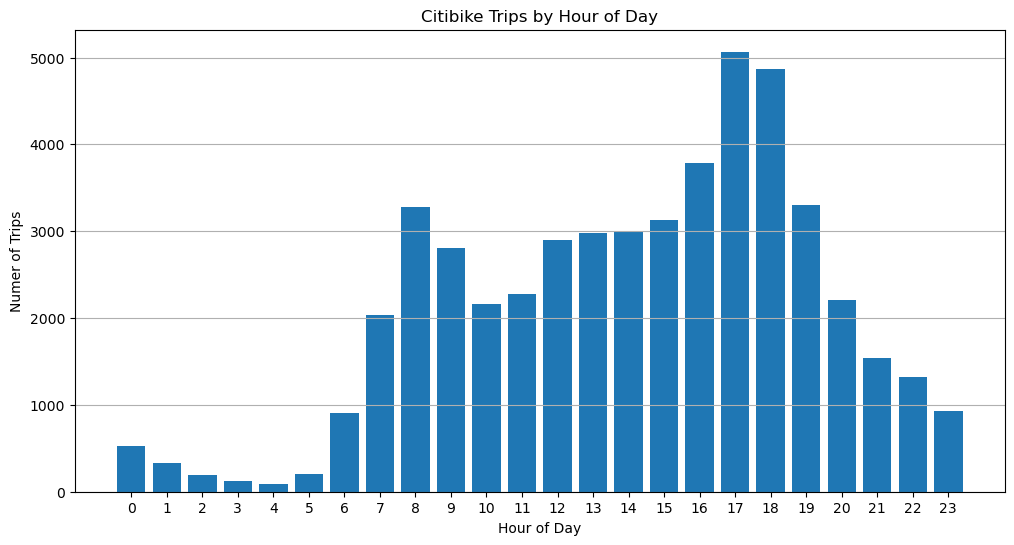

In [230]:
plt.figure(figsize=(12,6))
plt.bar(hourly_counts['start_hour'],hourly_counts['trip_count'])
plt.xlabel('Hour of Day')
plt.ylabel('Numer of Trips')
plt.title('Citibike Trips by Hour of Day')
plt.xticks(range(0,24))
plt.grid(axis='y')
plt.show()

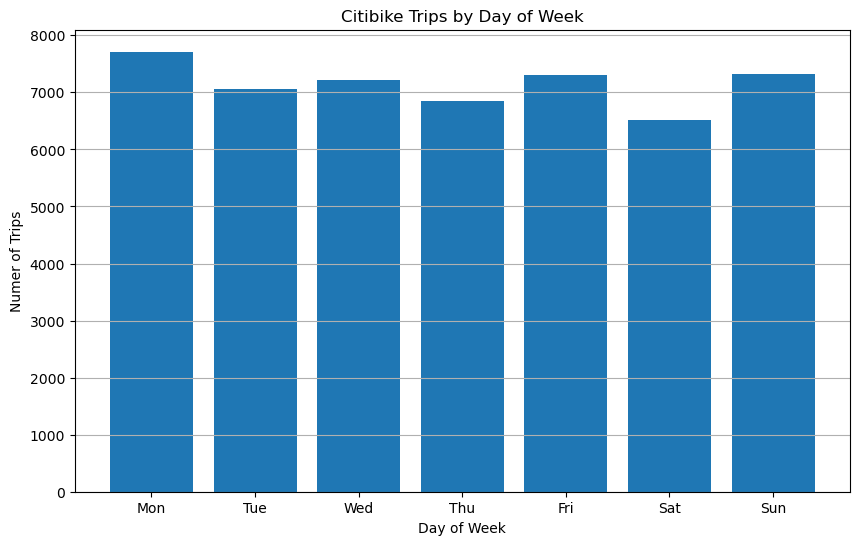

In [231]:
# Let's also look at trips by weekday
weekday_counts=df.groupby('weekday').size().reset_index(name='trip_count')
weekday_counts['weekday_num']=weekday_counts['weekday'].map(weekday_map)
weekday_counts=weekday_counts.sort_values('weekday_num')
plt.figure(figsize=(10,6))
plt.bar(weekday_counts['weekday'],weekday_counts['trip_count'])
plt.xlabel('Day of Week')
plt.ylabel('Numer of Trips')
plt.title('Citibike Trips by Day of Week')
plt.grid(axis='y')
plt.show()

In [232]:
# Set the hour of week as index for time series analysis
ts=weekday_hour_counts.set_index('hour_of_week')['trip_count']

# Check the length of time series

In [234]:
# Length of time series
len(ts)

168

In [235]:
#  Range of hour of week
ts.index.min()

0

In [236]:
ts.index.max()

167

In [237]:
# Number of unique hour_of_week values
ts.index.nunique()

168

In [238]:
# check if have all 168 hours in a week (0-167)
expected_hours=set(range(168))
actual_hours=set(ts.index)
missing_hours=expected_hours-actual_hours

In [239]:
# If have missing values need to fill them,fill missing values with 0 
if missing_hours:
    full_idx=pd.index(range(168),name='hour_of_week')
    ts_complete=ts.reindex(full_idx)
    ts_complete=ts_complete.fillna(0)
    len(ts_complete)
    ts=ts_complete

In [240]:
# trying the daily decomposition with the complete series
decomposition=seasonal_decompose(ts, model='addictive',period=24)

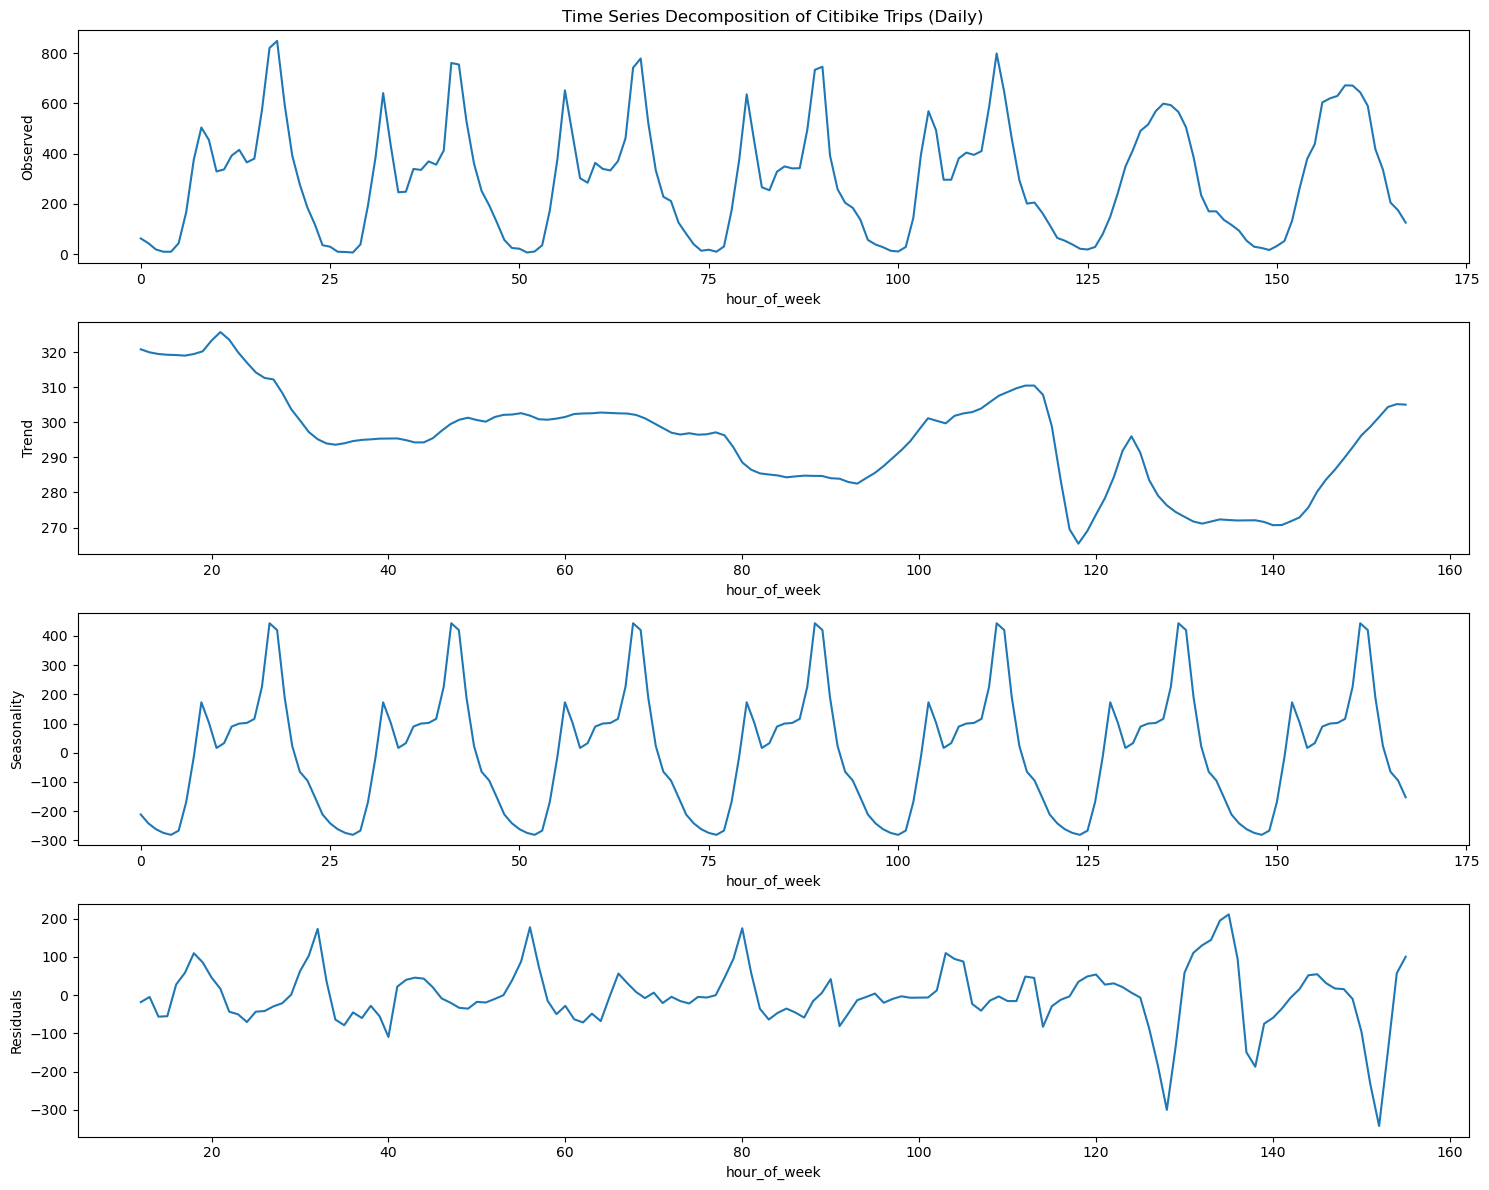

In [241]:
# Plot the decomposition
fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(15,12))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Time Series Decomposition of Citibike Trips (Daily)')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonality')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residuals')
plt.tight_layout()
plt.show()

# Analysing  Decomposition results:
Daily Decomposition(Period=24hours):
Observed: The original hourly trip counts show clear daily variation.
Trend: The trend component indicates gradual shifts in the overall bike usage level during the week. It smooths out the high-frequency noise.
Seasonality: The seasonal component captures repeated daily patterns, showing two distinct peaks corresponding to morning and evening rush hours.
Residuals: The residual component appears mostly random.Minor autocorrelations might suggest underlying complex interactions, but overall , the main patterns are well captured.

Discussion:

The clear two-pick pattern in the seasonal component supports the notion that citibike usage is strongly driven by commuting behaviors.
The trend component could be influenced by factors such as weather or special events,warranting further investigation if anomalies exist.
The residuals, being relatively random,imply that the additive model accurately captures the bulk of the varience in the data.
For forcusting purposes, the strong daily seasonality and some evidence of autocorrelation suggest that ARIMA  might be a suitable model.


# Dickey-Fuller Test on Time series Data

In [244]:
adf_result=adfuller(ts)

In [245]:
# unpack results
adf_statistic=adf_result[0]
p_value=adf_result[1]

In [246]:
# Create dictionary to disolay result
result_dict={
    'ADF Statistic':adf_statistic,
    'p-value': p_value,
    'Critical Values': adf_result[4]
}
    

In [247]:
result_dict

{'ADF Statistic': -8.473016627080632,
 'p-value': 1.460349520843256e-13,
 'Critical Values': {'1%': -3.473829775724492,
  '5%': -2.880622899711496,
  '10%': -2.5769448985432954}}

# Interpretation of the Dickey-Fuller interpretation:
The null hypothesis for the Dickey-Fuller test is that the time series has a unit root, meaning it is non stationery.In the test:
The ADF Statistic is significantly lower than the critical values at the 1%,5%, and 10% levels.
The p-value is extremly low(approximately 1.46e-13).

Since ADF statistic is less than the critical values and the p-value is well below the typical significance level(e.g.,0.05), we reject the null hypothesis , This indecates that the citibike trip count time series is stationary.

# The Dickey-Fullertest results indecate that our time series data is already stationary.Differencing is typically applied to non-stationary data to make it stationary by removing trends or seasonal patterns.